# **ENGG680 - Introduction to Digital Engineering**
## *Lab Assignment 3: Introduction to Machine Learning (Gradient Descent, Logistic Regression)*

## Preliminary: Certificate of Work


*We, the undersigned, certify that this is our own work, which has been done expressly for this course, either without the assistance of any other party or where appropriate we have acknowledged the work of others. Further, we have read and understood the section in the university calendar on plagiarism/cheating/other academic misconduct and we are aware of the implications thereof. We request that the total mark for this assignment be distributed as follows among group members:*

|          | First Name | Last Name | Signature (Full Name, Date) | Hours | Contribution % |
|----------|------------|-----------|-----------------------------|-------|----------------|
| Member 1: | Seyram | Atsu Quist | SeyramAtsuQuist,4/11/24 | 5 | 25 |
| Member 2: | Akosua | Gyimah | AkosuaGyimah,27/10/24 | 5 | 25 |
| Member 3: | Joseph | Mills | Josephmills,5/11/24 | 5 | 25 |
| Member 4: | Gideon | Asamoah | GideonAsamoah,5/11/24 | 5 | 25 |


# **Non-linear Gradient Descent (25 marks)**

### **Observations:** Pseudorange [m]

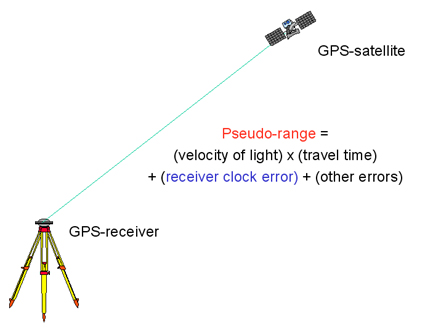

<font size="1.5">Image source: *ICA Course on Toponymy. https://unstats.un.org/unsd/geoinfo/ungegn/docs/_data_icacourses/_HtmlModules/_Selfstudy/S06/S06_05b.html.*</font>

**Pseudorange** is the *pseudo* distance between a satellite and a satellite signal receiver on the ground. In simple words, it contains the geometric range between the satellite and the receiver, with additional associated errors.

The simplified version of the Pseudorange measurement model is:
$$P=\rho-cdT+ϵ_{sum}$$ and
$$\rho=\sqrt{(x_s - x_r)^2 + (y_s - y_r)^2 + (z_s - z_r)^2}$$
where
$$\rho=geometric\ range$$
$${x_s, y_s, z_s, x_r,y_r,z_r} = 3D\ coordinates\ of\ satellite\ and\ receiver$$
$$cdT = receiver\ clock\ offset$$
$$ϵ_{sum}=general\ errors\ term\ (ϵ_{sum}=\Delta \rho + \Delta_{\text{ion}} + \Delta_{\text{trop}} + \epsilon_P + cdt)$$

\\
Note: the 3D **positions of satellites** are given in this assignment.

### **Unknown States:** Position of receiver & receiver clock offset

We use the psuedorange measurements to estimate the receiver's **3-dimensional position** and the **receiver clock offset:** $$X={x_r,y_r,z_r,cdT}$$.

These will be our states of interest, and we are going to estimate them using Gradient Descent method


.

###Step 0: Setup & Intialization

Step 0.1: Import necessary libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Step 0.2: Read and parse data files

In [ ]:
df_pseudorange = pd.read_excel('/content/drive/MyDrive/engg680_2024_fall/Lab_Assignment3/pseudoranges1.xlsx')
df_sat_pos = pd.read_excel('/content/drive/MyDrive/engg680_2024_fall/Lab_Assignment3/satellite_position1.xlsx')

pseudorange = df_pseudorange['P'].to_numpy()
sat_pos =df_sat_pos[['x','y','z']].to_numpy()

n = pseudorange.size

Step 0.3: Define the groundtruth of receiver's position in ECEF (m)

In [ ]:
GroundTruth=np.array([-1633489.37967725,	-3651627.18250363,	4952481.61954918])

Step 0.4: Intialize empty arrays

In [ ]:
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

Step 0.5: Function that
computes the euclidean distance between satellite and receiver

In [ ]:
def euclidean_norm(receiver_pos, satellite_pos):

    # Calculate the Euclidean norm (distance)
    distance = np.linalg.norm(satellite_pos - receiver_pos, axis =1)

    return distance


### Step 1: Define the Cost Function (4 marks)
Define a cost function that computes the sum of squared residuals between measured and predicted pseudoranges.

The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.

The function returns a single scalar.

Call euclidean_norm function to calculate geometric distance.

In [ ]:
# Cost function: sum of squared residuals between measured and predicted pseudoranges
def cost_function(r_pos, cdT, s_pos, pseudorange):
  L = np.mean((euclidean_norm(r_pos, s_pos)-cdT-pseudorange)**2)#
  return L

### Step 2: Define the Gradient Computation Function (4 marks)

Define a gradient computation function that calculates the gradient of the cost function with respect to the estimates (x_r, y_r, z_r, cdT).


The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.


The function returns a 1D numpy array that contains 4 elements.


Call euclidean_norm function to calculate geometric distance.


In [ ]:
# Gradient of the cost function with respect to the unknowns (x_r, y_r, z_r, cdT)
def gradient(r_pos, cdT, s_pos, pseudorange):
  rho = euclidean_norm(r_pos, s_pos)
  gradx = np.multiply(rho-cdT-pseudorange, np.divide(r_pos[0]-s_pos[:, 0], rho))
  grady = np.multiply(rho-cdT-pseudorange, np.divide(r_pos[1]-s_pos[:, 1], rho))
  gradz = np.multiply(rho-cdT-pseudorange, np.divide(r_pos[2]-s_pos[:, 2], rho))
  gradcdT = -rho+cdT+pseudorange
  grad = np.array([gradx, grady, gradz, gradcdT]).T
  grad = 2*np.mean(grad, axis=0)
  return grad

### Step 3: Gradient Descent Implementation (4 marks)
Construct the implementation function of gradient descent

Replace '...' with actual implementation

The function's input are: observed pseudoranges, satellites' positions, learning_rate, maximum loop iterations, tolerance

The function will return a 1D numpy array that contains the optimized estimates (x_r, y_r, z_r, cdT)

The function set learning_rate, max_iters and tolerance as: 0.01, 100000, 1e-6 as default values

These default hyperparameters values can be overridden by passing your own values when calling the function


In [ ]:
# Gradient descent algorithm for non-linear least squares estimation
def gradient_descent(pseudorange, s_pos, learning_rate=0.1, max_iters=10000, tolerance=1e-6):

    global steps_count

    #initalize the estimates as zeros
    X = np.array([0,0,0,0])

    for iteration in range(max_iters):
        r_pos = X[:3]
        cdT = X[3]

        # compute the cost in the current step
        # (1 mark)
        current_cost = cost_function(r_pos, cdT, s_pos, pseudorange)  #answered

        # compute the gradients in the current step
        # (1 mark)
        grad = gradient(r_pos, cdT, s_pos, pseudorange) #answered


        # update estimates
        # (1 mark)
        X_new = X - learning_rate * grad #answered

        # compute the new cost
        # (1 mark)
        new_cost = cost_function(X_new[:3], X_new[3], s_pos, pseudorange) #answered

        # break the loop if converge
        if np.abs(new_cost - current_cost) < tolerance:
            print("Converged !")
            steps_count=iteration
            break

        # update the parameters for the next iteration
        X = X_new

        #collect intermediate results for cost and gradients
        arr_cost.append(current_cost)
        arr_grad.append(grad)
        arr_err.append(X[:3]-GroundTruth)

    return X

### Step 4: Parameters Optimization & Results Printing (3 marks)

Call *gradient_descent* function to optimize the estimating parameters using default optimization hyperparameters

Print:

*   optimized parameters
*   final position errors of receiver
*   number of steps taken for convergence
*   final cost value
*   final gradient values








In [ ]:
optimized_params = gradient_descent(pseudorange, sat_pos)

# print the mentioned metrics
print("Optimized parameters:", optimized_params)
print("Final position errors of receiver:", arr_err[-1])
print("Number of steps taken for convergence:", steps_count)
print("Final cost value:", arr_cost[-1])
print("Final gradient values:", arr_grad[-1])

Converged !
Optimized parameters: [-1.63349244e+06 -3.65162953e+06  4.95248539e+06 -6.44838347e+00]
Final position errors of receiver: [-3.06240566 -2.34631388  3.77147769]
Number of steps taken for convergence: 2963
Final cost value: 0.5634455009259777
Final gradient values: [ 0.00015542  0.00086601 -0.00266161  0.00150894]


### Step 5: Cost vs Steps Plot & Analysis (2 marks)
Plot cost vs steps

Use 'semilogy' to scale y-axis

Label each axis

Include figure title

Comment on the pattern from the plot

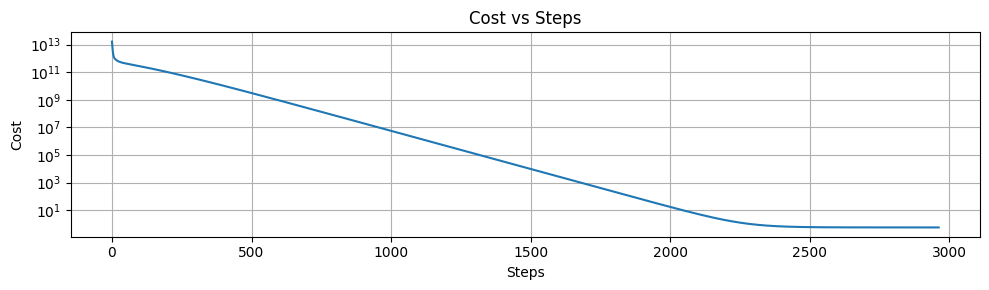

The graph shows a convergence of the cost between 2500-3000 iterations


In [ ]:
fig , ax = plt.subplots(nrows=1,ncols=1, figsize=(10,3))
ax.semilogy(arr_cost)
ax.set_xlabel('Steps')
ax.set_ylabel('Cost')
ax.set_title('Cost vs Steps')
ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern
print("The graph shows a convergence of the cost between 2500-3000 iterations")

### Step 6: Gradients vs Steps & Analysis(2 marks)
Plot gradients vs steps

use 'symlog' to scale y-axis

use 'tick_params' and set y-axis: labelsize=8

include axes' labels, legends and title

Comment on the pattern from the plot

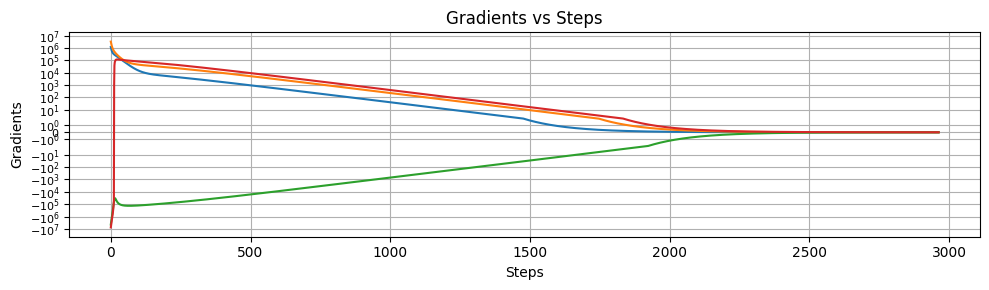

The graph shows a convergence of the gradients between 2200 to 2900 


In [ ]:
fig , ax = plt.subplots(nrows=1,ncols=1, figsize=(10,3))
ax.semilogy(arr_grad)
ax.tick_params(axis='y', labelsize=8)
ax.set_yscale('symlog')
ax.set_xlabel('Steps')
ax.set_ylabel('Gradients')
ax.set_title('Gradients vs Steps')
ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern
print("The graph shows a convergence of the gradients between 2200 to 2900 ")

### Step 7: Positioning errors vs Steps & Analysis(2 marks)
Plot positioning errors vs steps

Include axes' labels, legends and title

Comment on the pattern of the plot

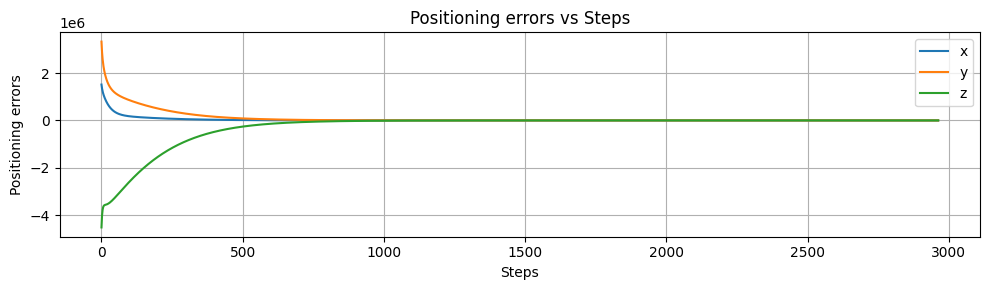

The position errors converege to zero between 750 to 2900.


In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
ax.plot(arr_err)
ax.set_xlabel('Steps')
ax.set_ylabel('Positioning errors')
ax.set_title('Positioning errors vs Steps')
plt.legend(['x', 'y', 'z'])
ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern
print("The position errors converege to zero between 750 to 2900.")

# Hyperparameters Tuning

### Step 8: Tuning Learning rate (2 marks)

Change learning rate to 0.01, 0.001 and repeat step 4.

(*hint: you may need to adjust the maximum loop iterations in this case*)

In [ ]:
#set learning rate to 0.01
#re-initialize arrays and counters
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

optimized_params_2 = gradient_descent(pseudorange, sat_pos, learning_rate=0.01, max_iters=500000)

# print the metrics
print("Optimized parameters:", optimized_params_2)
print("Final position errors of receiver:", arr_err[-1])
print("Number of steps taken for convergence:", steps_count)
print("Final cost value:", arr_cost[-1])
print("Final gradient values:", arr_grad[-1])

Converged !
Optimized parameters: [-1.63349244e+06 -3.65162950e+06  4.95248530e+06 -6.39730403e+00]
Final position errors of receiver: [-3.05714443 -2.31699848  3.68137918]
Number of steps taken for convergence: 27900
Final cost value: 0.5641548583233607
Final gradient values: [ 0.00048857  0.00272232 -0.00836683  0.0047434 ]


In [ ]:
#set learning rate to 0.001
#re-initialize arrays and counters
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

optimized_params_3 = gradient_descent(pseudorange, sat_pos, learning_rate=0.001, max_iters=500000)

# print the metrics
print("Optimized parameters:", optimized_params_3)
print("Final position errors of receiver:", arr_err[-1])
print("Number of steps taken for convergence:", steps_count)
print("Final cost value:", arr_cost[-1])
print("Final gradient values:", arr_grad[-1])

Converged !
Optimized parameters: [-1.63349242e+06 -3.65162941e+06  4.95248502e+06 -6.23556836e+00]
Final position errors of receiver: [-3.04048553 -2.2241755   3.39609526]
Number of steps taken for convergence: 260921
Final cost value: 0.5712616917838825
Final gradient values: [ 0.00154538  0.00861082 -0.02646466  0.01500358]


## Step 9: Results Analysis (2 marks)

Q1. Comment on the difference that you notice after changing the learning rate. (1 mark)

Q2. What is the difference between LSE and Gradient Descent? (Comment based on your results and the methodology) (1 mark)



ANSWER HERE

Question 1). Lower learning rates (0.01 and 0.001) required more iterations to converge. As the learning rate decreases, the more closer the optimized parameters are to the groundtruth. The final cost and gradient values also increases with respect to the decreasing learning rate.

Question 2).In gradient descent, we use the gradient vector to move toward the lowest point, while in least squares estimation (LSE), we use a design matrix to minimize the difference between the predicted values and the actual values. Our results showed that convergence was slower because the learning rate affects how the method behaves, making it more sensitive but also more precise.

---
---

# **Logistic Regression (50 marks)**

The following dataset helps to predict phishing webpages. It is collected mainly from: PhishTank archive, MillerSmiles archive, Googleâ€™s searching operators.

It can be downloaded from : https://archive.ics.uci.edu/dataset/327/phishing+websites

<u>Class labels:</u>

Not phishing = -1

Phishing = 1



Follow the steps provided to perform binary classification using logistic regression and complete the code for each part.


### Step 0: Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Step 1: Data Input (2 mark)

Use the `fetch_ucirepo(id=<ID>)`  to load the phishing dataset (id = 327) as a dataframe into the feature matrix `X` and target vector `y`.

Print the size of `X` and `y`


In [ ]:
!pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo

# Below code fetches dataset
phishing_websites = fetch_ucirepo(id=327)

# TO DO: data (as pandas dataframes) (1 mark)
data = phishing_websites.data
X = data.features
y = data.targets
X, y = X.to_numpy(), y.to_numpy()

# TO DO: display sizes of X and y (1 mark)
print(data)
print(X.shape, y.shape)
print(f"Sizes: X = {X.size}, y = {y.size}")

{'ids': None, 'features':        having_ip_address  url_length  shortining_service  having_at_symbol  \
0                     -1           1                   1                 1   
1                      1           1                   1                 1   
2                      1           0                   1                 1   
3                      1           0                   1                 1   
4                      1           0                  -1                 1   
...                  ...         ...                 ...               ...   
11050                  1          -1                   1                -1   
11051                 -1           1                   1                -1   
11052                  1          -1                   1                 1   
11053                 -1          -1                   1                 1   
11054                 -1          -1                   1                 1   

       double_slash_redirecting  pref

### Step 2.1: Class label histogram (2 marks)

Plot the histogram for each class label to visualise class imbalance. Additionally before calling .show() for the plot, ensure that the code displays you the exact value of the samples for each class above the respective bins.

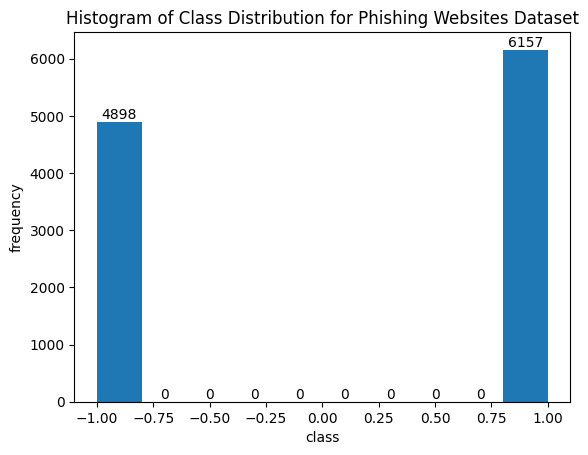

In [ ]:
# TO DO: Check the class distribution of y (2 mark)
counts, edges, bars = plt.hist(y)
plt.bar_label(bars)
plt.xlabel("class")
plt.ylabel("frequency")
plt.title("Histogram of Class Distribution for Phishing Websites Dataset")

# Display exact values for each bin in the histogram

plt.show()

### Step 2.2: Smaller dataset creation(2 mark)


We also want to test if the model would still work if we used less data. Use the `train_test_split` function from sklearn to create a new feature matrix named `X_small` and a new target vector named `y_small` that contain **3%** of the data.

Use random_state = 42


In [ ]:
# TO DO: Create a smaller dataset with 3% of the data
from sklearn.model_selection import train_test_split
_, X_small, _, y_small = train_test_split(X, y, test_size=0.03, random_state=42)

# TO DO: display sizes of X_small and y_small (2 mark)
print(X_small.shape, y_small.shape)
print(f"Sizes: X = {X_small.size}, y = {y_small.size}")

(332, 30) (332, 1)
Sizes: X = 9960, y = 332


### Step 3: Implement Machine Learning Model (6 marks)

1. Import `LogisticRegression` from sklearn
2. Instantiate model `LogisticRegression(max_iter=2000)`
3. Implement the machine learning model with three different datasets:
    - `X` and `y` (1 mark)
    - Only first two columns of `X` and `y` (1 mark)
    - `X_small` and `y_small` (1 mark)

### Step 4: Test Model (6 x 3 = 18 marks)

Calculate the following for the **three different tests** implemented in Step 3
1. data size (1 mark)
1. number of training samples (1 mark)
2. number of testing samples (1 mark)
4. training accuracy (1 marks)
5. testing accuracy (1 marks)
6. log loss (1 mark)

### Step 5.1: Visualize Results (3 marks)

1. Create a pandas DataFrame `results` with columns: Data size, training samples, testing samples, training accuracy, testing accuracy, log loss
2. Add these columns for each dataset to the `results` DataFrame
3. Print `results`

For any **random state** parameters from this step onwards, you can use random_state = 0;

In [ ]:
#TO DO: Complete steps 3,4, and 5.1 in this code block (Total 27 marks)

# Note: 70% training set, 30% testing set
# HINT: create a function that calculates all required information
import seaborn as sns

# TO DO: Calculate confusion matrix (2 marks) : conf_mat

# STEP 3

from sklearn.linear_model import LogisticRegression

lr1 = LogisticRegression(max_iter=2000, random_state=0)
lr2 = LogisticRegression(max_iter=2000, random_state=0)
lr3 = LogisticRegression(max_iter=2000, random_state=0)

# Instance 1
lr1.fit(X, y.reshape(-1,))

# Instance 2
lr2.fit(X[:, :2], y.reshape(-1,))

# Instance 3
lr3.fit(X_small, y_small.reshape(-1,))


# STEP 4
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

# data size
print(f"The data size for 1st instance X is: {X.size}, and y is: {y.reshape(-1,).size}.")
print(f"The data size for 2nd instance X is: {X[:, :2].size}, and y is: {y.reshape(-1,).size}.")
print(f"The data size for 3rd instance X is: {X_small.size}, and y is: {y_small.reshape(-1,).size}.")

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_cond_train, X_cond_test, y_cond_train, y_cond_test = train_test_split(X[:, :2], y, test_size=0.3, random_state=0)
X_small_train, X_small_test, y_small_train, y_small_test = train_test_split(X_small, y_small, test_size=0.3, random_state=0)

y_train = y_train.reshape(-1,)
y_test = y_test.reshape(-1,)
y_cond_train = y_cond_train.reshape(-1,)
y_cond_test = y_cond_test.reshape(-1,)
y_small_train = y_small_train.reshape(-1,)
y_small_test = y_small_test.reshape(-1,)

# print number of training samples
print(f"The number of training samples for 1st instance is: {X_train.shape[0]}.")
print(f"The number of training samples for 2nd instance is: {X_cond_train.shape[0]}.")
print(f"The number of training samples for 3rd instance is: {X_small_train.shape[0]}.")

# print number of testing samples
print(f"The number of testing samples for 1st instance is: {X_test.shape[0]}.")
print(f"The number of testing samples for 2nd instance is: {X_cond_test.shape[0]}.")
print(f"The number of testing samples for 3rd instance is: {X_small_test.shape[0]}.")

# training accuracy
lr1.fit(X_train, y_train)
ytr1 = lr1.predict(X_train)
trainAcc1 = accuracy_score(y_train, ytr1)
lr2.fit(X_cond_train, y_cond_train)
ytr2 = lr2.predict(X_cond_train)
trainAcc2 = accuracy_score(y_cond_train, ytr2)
lr3.fit(X_small_train, y_small_train)
ytr3 = lr3.predict(X_small_train)
trainAcc3 = accuracy_score(y_small_train, ytr3)
print(f"The training accuracy for 1st instance is: {trainAcc1}.")
print(f"The training accuracy for 2nd instance is: {trainAcc2}.")
print(f"The training accuracy for 3rd instance is: {trainAcc3}.")

# testing accuracy
yt1=lr1.predict(X_test)
testAcc1 = accuracy_score(y_test, yt1)
yt2=lr2.predict(X_cond_test)
testAcc2 = accuracy_score(y_cond_test, yt2)
yt3=lr3.predict(X_small_test)
testAcc3 = accuracy_score(y_small_test, yt3)
print(f"The testing accuracy for 1st instance is: {testAcc1}.")
print(f"The testing accuracy for 2nd instance is: {testAcc2}.")
print(f"The testing accuracy for 3rd instance is: {testAcc3}.")

# log loss
ll1 = log_loss(y_test, yt1)
ll2 = log_loss(y_cond_test, yt2)
ll3 = log_loss(y_small_test, yt3)
print(f"Log loss for 1st instance is: {ll1}.")
print(f"Log loss for 2nd instance is: {ll2}.")
print(f"Log loss for 3rd instance is: {ll3}.")


# STEP 5.1
colnames = ["Data Size", "Training Samples", "Testing Samples", "Training Accuracy", "Testing Accuracy", "Log Loss"]
indexnames=["Ins_1", "Ins_2", "Ins_3"]
i1 = [X.size, X_train.shape[0], X_test.shape[0], trainAcc1, testAcc1, ll1]
i2 = [X[:, :2].size, X_cond_train.shape[0], X_cond_test.shape[0], trainAcc2, testAcc2, ll2]
i3 = [X_small.size, X_small_train.shape[0], X_small_test.shape[0], trainAcc3, testAcc3, ll3]
datamatrix = np.array([i1, i2, i3])
results = pd.DataFrame(datamatrix, index=indexnames, columns=colnames)
print(f"\nOur results:\n{results}")
# Below code prints confusion matrix using a heatmap


The data size for 1st instance X is: 331650, and y is: 11055.
The data size for 2nd instance X is: 22110, and y is: 11055.
The data size for 3rd instance X is: 9960, and y is: 332.
The number of training samples for 1st instance is: 7738.
The number of training samples for 2nd instance is: 7738.
The number of training samples for 3rd instance is: 232.
The number of testing samples for 1st instance is: 3317.
The number of testing samples for 2nd instance is: 3317.
The number of testing samples for 3rd instance is: 100.
The training accuracy for 1st instance is: 0.9322822434737659.
The training accuracy for 2nd instance is: 0.5628069268544844.
The training accuracy for 3rd instance is: 0.9741379310344828.
The testing accuracy for 1st instance is: 0.9228218269520652.
The testing accuracy for 2nd instance is: 0.5568284594513114.
The testing accuracy for 3rd instance is: 0.89.
Log loss for 1st instance is: 2.7817833185450684.
Log loss for 2nd instance is: 15.973521399458008.
Log loss for 3r

### Step 5.2: Visualize Classification Errors (6 marks)

In this section, print the confusion matrix and the classification report to investigate the number of false positives vs. false negatives. Use the full dataset for this analysis

In [ ]:
# TO DO: Retrieve target vector and predicted values for testing set using full dataset and print the dimension of the predicted output (2 mark)
# Note: 70% training set, 30% testing set

print(f"Dimension of predicted output: {yt1.shape}.")

Dimension of predicted output: (3317,).


Confusion matrix: [[1341  157]
 [  99 1720]].


Text(113.9222222222222, 0.5, 'true value')

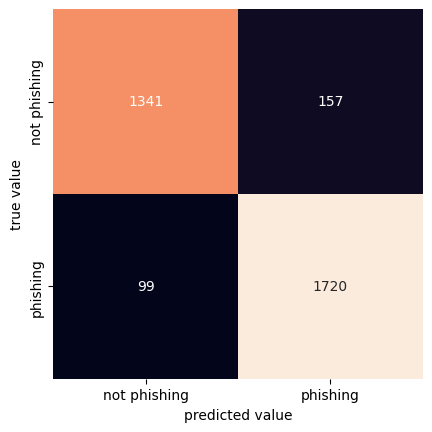

In [ ]:
import seaborn as sns

# TO DO: Calculate confusion matrix (2 marks) : conf_mat
from sklearn.metrics import confusion_matrix, classification_report

conf_mat = confusion_matrix(y_test, yt1)
print(f"Confusion matrix: {conf_mat}.")

# Below code prints confusion matrix using a heatmap
sns.heatmap(conf_mat, xticklabels=['not phishing', 'phishing'],  yticklabels=['not phishing', 'phishing'], square=True, annot=True, cbar=False, fmt='d')
plt.xlabel('predicted value')
plt.ylabel('true value')



### Questions (11 marks)
1. Is the dataset imbalanced? Does it affect model performance? (1 mark)
2. Does the model overfit or underfit for each of the 3 cases? (3 marks)
3. How do the training and testing accuracy change depending on the amount of data used? Explain with values. (1 mark)
4. In this case, what do a false positive and a false negative represent? Which one is worse? (2 marks)
5. Based on your answer to question 4, would you want to maximize precision or recall? How would you do this? (2 marks)
6. Based on the Log Loss for each of the 3 cases, what can you say about the model in each instance? What is potentially causing these differences? (2 mark)


ANSWER HERE

---
---

In [ ]:
print(f"Q1) The data is almost balanced with a -1 support of {np.round(1498*100/3317, decimals=3)}% and a 1 support of {np.round(1819*100/3317, decimals=3)}%,\nNonetheless, class -1 performs worse overall than the 1 predictions.\nThis is probably the reason.")

Q1) The data is almost balanced with a -1 support of 45.161% and a 1 support of 54.839%,
Nonetheless, class -1 performs worse overall than the 1 predictions.
This is probably the reason.


In [ ]:
print(f"Q2) The testing and training accuracies for the first and second implementations do not differ much.The models are not overfit as a result.\nNevertheless, we conclude that the final model is overfit since it reports an accuracy of.89 in its test set and.97 in its training set.\nFurthermore, the second model's poor performance on the training and testing sets raises the possibility that it is not well-suited to the actual situation.")

Q2) The testing and training accuracies for the first and second implementations do not differ much.The models are not overfit as a result.
Nevertheless, we conclude that the final model is overfit since it reports an accuracy of.89 in its test set and.97 in its training set.
Furthermore, the second model's poor performance on the training and testing sets raises the possibility that it is not well-suited to the actual situation.


In [ ]:
print(f"Q3) A complete dataset with all features and samples is used in the first implementation, which has a testing accuracy of  0.9228218269520652 and a training accuracy of 0.9322822434737659.\nIn contrast to a set that decreases the number of characteristics while keeping the same number of samples,\nTraining 0.5628069268544844 and testing 0.5568284594513114 show a notable underperformance, suggesting that the feature space is insufficient to fully represent the dataset's complexity.\nThe final model indicates that the dataset outperforms the second implementation despite having less samples but sufficient characteristics.\nThe model overfits to the sample space, which is a disadvantage of insufficient data. This is demonstrated by the testing accuracy of 0.89 and the training accuracy of 0.9741379310344828.")

Q3) A complete dataset with all features and samples is used in the first implementation, which has a testing accuracy of  0.9228218269520652 and a training accuracy of 0.9322822434737659.
In contrast to a set that decreases the number of characteristics while keeping the same number of samples,
Training 0.5628069268544844 and testing 0.5568284594513114 show a notable underperformance, suggesting that the feature space is insufficient to fully represent the dataset's complexity.
The final model indicates that the dataset outperforms the second implementation despite having less samples but sufficient characteristics.
The model overfits to the sample space, which is a disadvantage of insufficient data. This is demonstrated by the testing accuracy of 0.89 and the training accuracy of 0.9741379310344828.


In [ ]:
print(f"Q4) When a non-phishing website is mistakenly identified as phishing, this is known as a false positive.\nWhen improper websites are assumed to be normal, false negatives happen.\nIt's difficult to say because, if left unnoticed, a rogue website could infect your machine with malware.\nHowever, a server or website at work may experience an FP, which could be just as inconvenient. Given the increased danger of malware, having a FN may make this issue worse.\nTroubleshooting would be necessary in any case.")

Q4) When a non-phishing website is mistakenly identified as phishing, this is known as a false positive.
When improper websites are assumed to be normal, false negatives happen.
It's difficult to say because, if left unnoticed, a rogue website could infect your machine with malware.
However, a server or website at work may experience an FP, which could be just as inconvenient. Given the increased danger of malware, having a FN may make this issue worse.
Troubleshooting would be necessary in any case.


In [ ]:
print(f"Q5) Passing a non-phishing website as phishing is less risky, in our opinion, than passing a phishing website as authentic.\nTherefore, we think that using the formula TP/(TP+FN) to maximize recall will also decrease our FNs.")

Q5) Passing a non-phishing website as phishing is less risky, in our opinion, than passing a phishing website as authentic.
Therefore, we think that using the formula TP/(TP+FN) to maximize recall will also decrease our FNs.


In [ ]:
print(f"Q6) The model's performance and likelihood of being overfit or underfit for predictions are shown by the log loss.\nThe performance of the model deteriorates with increasing loss.\nAdditionally, this makes underfitting and overfitting more likely.")

Q6) The model's performance and likelihood of being overfit or underfit for predictions are shown by the log loss.
The performance of the model deteriorates with increasing loss.
Additionally, this makes underfitting and overfitting more likely.
